In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,os.path

import datastack.dbs.rdb
from datastack.dbs import rdb as rosetta
import datastack.ml.baselines as baselines
import datastack.ml.baseregress as baseregress
import datastack.ml.cross_validation as cross_validation
import datastack.utilities.gui as gui
from datastack.tools import vdbwrapper
from datastack.dbs import vdb as vdbclass

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import operator
import json
from  scipy.spatial.distance import cosine

import datastack.ml.DepthColorPCs as face_models
import pickle

vdbclass = reload(vdbclass)
gui = reload(gui)
vdbwrapper = reload(vdbwrapper)
cross_validation = reload(cross_validation)
face_models = reload(face_models)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
models = face_models.DepthColorPCs()

Our final model for Depth PCs: 1000 global genomic PCs, actual age, actual bmi, actual gender. Ridge regression.

In [13]:
##########################################
## 1000 Global PCs DepthPCs Predictions ##
##########################################
# Our final model for Depth PCs
m=1000
genPCs = ["genomics.kinship.pc."+str(x) for x in xrange(1,m+1,1)]
baseDepth = models.predictDepthPCs(covPCs=genPCs)
baseDepthCV=baseDepth.cv[('AGE + BMI', 'multi', 0)]
est = baseDepthCV.get_estimator()
s = pickle.dump(est,open("depth-PCs-model.pkl", 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

904 samples,Covariates,SELECT10,R2,pc38: R2,pc39: R2,pc18: R2,pc19: R2,pc14: R2,pc15: R2,pc16: R2,pc17: R2,pc10: R2,pc11: R2,pc12: R2,pc13: R2,pc43: R2,pc32: R2,pc42: R2,pc41: R2,pc25: R2,pc24: R2,pc27: R2,pc26: R2,pc21: R2,pc20: R2,pc23: R2,pc22: R2,pc47: R2,pc49: R2,pc48: R2,pc29: R2,pc28: R2,pc46: R2,pc33: R2,pc31: R2,pc45: R2,pc36: R2,pc44: R2,pc37: R2,pc34: R2,pc35: R2,pc30: R2,pc8: R2,pc9: R2,pc40: R2,pc2: R2,pc3: R2,pc1: R2,pc6: R2,pc7: R2,pc4: R2,pc5: R2,pc50: R2
Mean,,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Median,,0.000,0.000,-0.000,-0.000,-0.001,-0.002,-0.006,-0.006,-0.001,-0.000,-0.001,-0.000,-0.002,-0.001,-0.000,-0.000,-0.001,-0.001,-0.001,-0.003,-0.000,-0.002,-0.000,-0.007,-0.000,-0.000,-0.000,-0.000,-0.000,-0.001,-0.000,-0.000,-0.001,-0.000,-0.006,-0.003,-0.000,-0.000,-0.000,-0.000,-0.000,-0.002,-0.003,-0.000,-0.006,-0.000,-0.002,-0.000,-0.000,-0.002,-0.000,-0.000
Ridge,Age,0.150,0.010,-0.003,0.002,0.017,0.018,0.057,0.015,-0.005,0.054,0.010,-0.009,0.091,0.010,-0.005,0.000,-0.006,0.001,-0.005,0.004,0.010,-0.006,-0.001,0.009,-0.006,0.011,-0.004,-0.002,-0.003,-0.003,-0.005,-0.001,-0.005,0.014,0.020,-0.006,-0.005,0.004,-0.005,0.006,0.003,0.002,0.049,-0.009,0.168,-0.003,0.009,-0.003,-0.004,-0.001,0.036,-0.004
Ridge,Gender,0.199,0.015,-0.005,-0.007,-0.006,-0.002,-0.004,0.022,0.007,-0.003,0.008,-0.006,0.001,0.019,-0.003,-0.003,-0.007,-0.005,-0.006,-0.005,-0.002,-0.005,-0.001,-0.004,-0.003,-0.006,-0.003,-0.006,-0.002,-0.003,-0.005,-0.005,-0.001,-0.005,-0.004,-0.005,-0.004,0.003,-0.002,-0.001,-0.004,0.034,0.001,-0.009,0.279,0.125,0.309,-0.001,-0.002,0.015,0.064,-0.004
Ridge,Ethnicity,0.257,0.034,-0.007,-0.001,0.002,0.028,0.022,0.048,0.019,0.037,0.020,0.054,0.022,0.009,-0.009,-0.012,-0.001,0.012,0.027,0.009,-0.014,-0.003,0.011,0.012,0.007,-0.006,0.015,0.009,-0.011,-0.001,0.010,0.011,-0.030,0.003,-0.023,-0.006,0.002,-0.006,0.014,0.001,-0.003,0.063,0.003,-0.014,0.587,0.059,0.118,0.060,0.080,0.281,0.189,-0.019
Ridge,AGE,0.411,0.063,-0.008,0.000,0.027,0.046,0.074,0.103,0.033,0.105,0.067,0.046,0.114,0.061,-0.014,-0.005,-0.007,0.015,0.020,0.010,0.004,-0.011,0.010,0.027,0.006,0.005,0.009,0.008,-0.012,0.001,0.006,0.010,-0.032,0.025,-0.005,-0.007,0.001,0.007,0.017,0.012,0.002,0.101,0.057,-0.023,0.762,0.182,0.453,0.070,0.089,0.323,0.391,-0.024
Ridge,AGE + BMI,0.482,0.070,-0.009,-0.002,0.025,0.045,0.072,0.101,0.027,0.107,0.065,0.048,0.119,0.063,-0.013,0.005,-0.007,0.013,0.037,0.025,0.003,-0.012,0.009,0.035,0.003,0.003,0.007,0.007,-0.016,0.008,0.005,0.010,-0.033,0.036,-0.010,-0.009,-0.000,0.004,0.015,0.020,0.002,0.108,0.057,-0.025,0.768,0.208,0.608,0.078,0.119,0.421,0.394,-0.025
Ridge,BMI,0.172,0.007,-0.005,-0.005,-0.002,0.003,0.003,-0.004,-0.008,-0.002,0.003,0.001,0.020,-0.003,-0.001,0.006,-0.005,-0.006,0.019,0.003,-0.004,-0.003,-0.002,0.004,-0.006,-0.002,-0.002,-0.005,-0.004,-0.000,-0.004,-0.003,-0.004,0.012,-0.004,-0.005,-0.005,-0.005,-0.006,0.001,-0.003,0.004,-0.002,-0.007,0.144,0.025,0.150,0.003,0.036,0.031,-0.000,-0.002


Here is the graph of r^2 scores vs. Ridge alpha parameter values.

0.525326108903


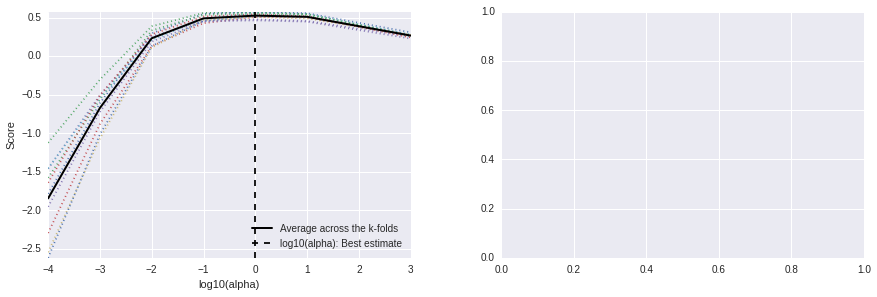

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 9)
axes = gui.get_subplots(plt, 1, 4, 2, 6) 
baseDepthCV.plot_scores_vs_params(axes[0][0], x_log10=True)
print(np.max(np.mean(baseDepthCV._get_scores_vs_params(),axis=1)))


Predict color PCs using 1000 global genomic PCs, actual age, 7 SNPs. Ridge regression.

In [15]:
###########################################
## 1000 Global PCs Color PCs Predictions ##
###########################################
m=1000
genPCs = ["genomics.kinship.pc."+str(x) for x in xrange(1,m+1,1)]
baseColor = models.predictColorPCs(covPCs=genPCs)
baseColorCV=baseColor.cv[('AGE + SNPs', 'multi', 0)]
estCol = baseColorCV.get_estimator()
sCol = pickle.dump(estCol,open("color-PCs-model.pkl", 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

904 samples,Covariates,SELECT10,R2,pc38: R2,pc39: R2,pc18: R2,pc19: R2,pc14: R2,pc15: R2,pc16: R2,pc17: R2,pc10: R2,pc11: R2,pc12: R2,pc13: R2,pc43: R2,pc32: R2,pc42: R2,pc41: R2,pc25: R2,pc24: R2,pc27: R2,pc26: R2,pc21: R2,pc20: R2,pc23: R2,pc22: R2,pc47: R2,pc49: R2,pc48: R2,pc29: R2,pc28: R2,pc46: R2,pc33: R2,pc31: R2,pc45: R2,pc36: R2,pc44: R2,pc37: R2,pc34: R2,pc35: R2,pc30: R2,pc8: R2,pc9: R2,pc40: R2,pc2: R2,pc3: R2,pc1: R2,pc6: R2,pc7: R2,pc4: R2,pc5: R2,pc50: R2
Mean,,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Median,,0.000,0.000,-0.000,-0.000,-0.001,-0.000,-0.001,-0.002,-0.000,-0.000,-0.003,-0.000,-0.001,-0.000,-0.000,-0.002,-0.001,-0.001,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.001,-0.000,-0.000,-0.005,-0.000,-0.000,-0.002,-0.001,-0.000,-0.000,-0.000,-0.001,-0.001,-0.000,-0.002,-0.000,-0.001,-0.002,-0.002,-0.012,-0.007,-0.001,-0.000,-0.003,-0.001,-0.002
Ridge,Age,0.162,0.009,-0.002,0.004,0.014,-0.005,0.004,0.001,-0.004,0.014,0.049,0.026,-0.001,-0.000,-0.003,0.006,0.003,-0.001,0.011,0.005,0.006,-0.005,-0.006,-0.004,-0.002,-0.004,-0.001,-0.008,0.002,0.010,-0.001,0.003,-0.003,-0.009,-0.001,0.022,-0.004,0.016,-0.007,-0.003,-0.004,-0.002,-0.003,-0.002,0.032,0.090,0.128,0.018,0.003,0.047,0.005,-0.004
Ridge,Gender,0.181,0.013,-0.004,-0.006,0.001,-0.005,-0.002,0.001,-0.005,0.005,0.004,0.005,0.000,-0.003,-0.003,-0.004,-0.003,-0.008,-0.003,-0.000,-0.003,-0.007,-0.001,-0.005,-0.004,0.004,-0.003,-0.006,-0.007,-0.004,-0.004,-0.004,-0.000,-0.003,-0.006,-0.006,0.000,-0.004,0.007,-0.003,-0.004,0.002,-0.002,-0.002,0.020,0.648,-0.005,0.096,-0.004,0.010,-0.001,-0.003
Ridge,Ethnicity,0.247,0.031,0.009,-0.012,0.002,0.050,0.056,0.040,0.031,0.001,0.008,0.044,0.025,0.008,-0.006,0.010,-0.012,-0.024,0.000,0.008,-0.001,-0.018,-0.011,0.014,-0.011,-0.003,0.006,-0.014,-0.015,0.022,0.001,0.003,-0.008,-0.022,-0.025,-0.013,-0.007,-0.013,0.002,-0.008,-0.019,0.083,0.016,-0.008,0.026,0.039,0.762,0.033,0.069,0.311,0.108,-0.015
Ridge,AGE,0.388,0.056,0.005,-0.007,0.014,0.046,0.068,0.046,0.038,0.026,0.109,0.107,0.024,0.009,-0.007,0.019,-0.006,-0.033,0.025,0.013,0.007,-0.023,-0.012,0.010,-0.004,0.006,0.006,-0.012,-0.015,0.032,0.000,0.005,-0.006,-0.029,-0.019,0.020,-0.006,-0.001,0.009,-0.010,-0.017,0.090,0.014,-0.007,0.101,0.702,0.795,0.161,0.067,0.347,0.105,-0.020
Ridge,AGE + SNPs,0.395,0.052,0.001,-0.014,0.006,0.044,0.064,0.055,0.033,0.018,0.105,0.104,0.023,0.005,-0.008,0.009,-0.014,-0.045,0.019,-0.002,0.005,-0.031,-0.020,0.011,-0.006,0.016,0.004,-0.022,-0.026,0.022,-0.003,-0.012,0.006,-0.036,-0.019,0.009,-0.016,-0.011,0.001,-0.019,-0.014,0.084,0.015,-0.020,0.085,0.701,0.809,0.165,0.086,0.350,0.116,-0.036
Ridge,SNPs,0.231,0.019,-0.002,-0.005,-0.009,0.001,0.028,0.032,0.002,-0.011,0.001,0.038,0.030,0.005,-0.008,-0.008,-0.013,-0.010,0.000,-0.014,-0.009,-0.011,-0.017,-0.004,-0.006,-0.008,0.003,-0.015,-0.010,-0.001,0.000,-0.013,-0.004,-0.011,-0.007,-0.013,-0.011,-0.012,-0.005,-0.007,-0.002,0.059,0.007,-0.016,-0.010,0.006,0.706,0.015,0.044,0.252,0.030,-0.016


Example of Depth and Color PC prediction using pickled model:

In [18]:
data_dir="./"
modelDepthPCs_file = open(os.path.join(data_dir, 'depth-PCs-model.pkl'))
modelColorPCs_file = open(os.path.join(data_dir, 'color-PCs-model.pkl'))
modelDepthPCs = pickle.load(modelDepthPCs_file)
modelColorPCs = pickle.load(modelColorPCs_file)


Let's predict and visualize a face:

In [85]:
featuresDepth = models.data.ix[models.data.index[800],modelDepthPCs.hli_features] #baseDepth.covariates['AGE + BMI']] #modelDepthPCs.hli_features]
featuresColor = models.data.ix[models.data.index[800],modelColorPCs.hli_features] #baseColor.covariates['AGE + SNPs']] #modelColorPCs.hli_features]

In [86]:
# Model predicts PCs not in order
indexes=[]
lst = list(baseDepthCV.y.columns)
for itm in list(depthPCs):
    indexes.append(lst.index(itm))


predDepthPCs=[]
predColorPCs=[]
preds = list(modelDepthPCs.predict(featuresDepth)[0])
preds_color = list(modelColorPCs.predict(featuresColor)[0])
for idx in indexes:
    predDepthPCs.append(preds[idx])
    predColorPCs.append(preds_color[idx])


/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [87]:
m=50
n=1000
depthPCs = ["dynamic.FACE.face.v2_visit1.DepthPC."+str(x) for x in xrange(1,m+1,1)]
colorPCs = ["dynamic.FACE.face.v2_visit1.ColorPC."+str(x) for x in xrange(1,m+1,1)]
actual_depthPCs = ["dynamic.FACE.face.v2_visit1.DepthPC."+str(x) for x in xrange(1,n+1,1)]
actual_colorPCs = ["dynamic.FACE.face.v2_visit1.ColorPC."+str(x) for x in xrange(1,n+1,1)]
trueDepthPCs = np.array(models.data.ix[models.data.index[800],depthPCs])
trueColorPCs = np.array(models.data.ix[models.data.index[800],colorPCs])
actualDepthPCs = np.array(models.data.ix[models.data.index[800],actual_depthPCs])
actualColorPCs = np.array(models.data.ix[models.data.index[800],actual_colorPCs])

In [88]:
def render_3d(frr, name, _test_depth, _test_color, _pred_depth, _pred_color):

    #name, _test_depth, _test_color, _pred_depth, _pred_color = _get_comapre_data(name)

    print "Subject {}".format(name)
    _, _, id_test = frr.generate_obj(x=_test_depth, z=_test_color, quality=5, extended=True)
    _, _, id_pred = frr.generate_obj(x=_pred_depth, z=_pred_color, quality=5, extended=True)


def render_compare_2d(frr, name, _test_depth, _test_color, _pred_depth, _pred_color, store=False, plot=True):

    import matplotlib.image as mpimg
    import matplotlib.pylab as plt
    from numpy import linalg, array

    #name, _test_depth, _test_color, _pred_depth, _pred_color = self._get_comapre_data(name)

    res_png_test, _, id_test = frr.generate_2d(x=_test_depth, z=_test_color, quality=5)
    res_png_pred, _, id_pred = frr.generate_2d(x=_pred_depth, z=_pred_color, quality=5)
    tp_dist                  = linalg.norm(array(_test_depth) - array(_pred_depth))

    tp_dist_color            = linalg.norm(array(_test_color) - array(_pred_color))

    img_test = mpimg.imread(res_png_test)
    img_pred = mpimg.imread(res_png_pred)

    fig     = plt.figure()
    ax      = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img_test)
    ax.set_title("Subject {}".format(name))
    ax.axis('off')

    ax      = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(img_pred)
    ax.set_title('D: {0:.2e} C: {1:.2e}'.format(tp_dist, tp_dist_color))
    #else:
    #    ax.set_title('D: {0:.2e}'.format(tp_dist))
    ax.axis('off')

    if store:

        #if not self.stored:
        #    self.store()

        fname = os.path.join("./", "{}.png".format(name))
        plt.savefig(fname)
        plt.close(fig)

    elif plot:
        plt.show()

def render_compare_2d_3img(frr, name, _actual_depth, _actual_color, _test_depth, _test_color, _pred_depth, _pred_color, store=False, plot=True):

    import matplotlib.image as mpimg
    import matplotlib.pylab as plt
    from numpy import linalg, array

    #name, _test_depth, _test_color, _pred_depth, _pred_color = self._get_comapre_data(name)
    res_png_actual, _, id_actual = frr.generate_2d(x=_actual_depth, z=_actual_color, quality=5)
    res_png_test, _, id_test = frr.generate_2d(x=_test_depth, z=_test_color, quality=5)
    res_png_pred, _, id_pred = frr.generate_2d(x=_pred_depth, z=_pred_color, quality=5)
    tp_dist                  = linalg.norm(array(_test_depth) - array(_pred_depth))
    #heatmap_dist                  = array(_test_depth) - array(_pred_depth)

    
    tp_dist_color            = linalg.norm(array(_test_color) - array(_pred_color))

    img_actual = mpimg.imread(res_png_actual)    
    img_test = mpimg.imread(res_png_test)
    img_pred = mpimg.imread(res_png_pred)

    fig     = plt.figure()
    ax      = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(img_actual)
    ax.set_title("{}".format(name))
    ax.axis('off')
    
    ax      = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(img_test)
    ax.set_title("50PCs".format(name))
    ax.axis('off')

    ax      = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(img_pred)
    
    ax.set_title('D: {0:.2e} C: {1:.2e}'.format(tp_dist, tp_dist_color))
    #ax.set_title('D: {0:.2e}'.format(tp_dist))
    ax.axis('off')

    if store:

        #if not self.stored:
        #    self.store()

        fname = os.path.join("./face_predictions/", "{}.png".format(name))
        plt.savefig(fname)
        plt.close(fig)

    elif plot:
        plt.show()


In [89]:
import ast
from datastack.tools import facerenderer
reload(facerenderer)
#facerenderer.FaceRenderer.install_ipython()
frr = facerenderer.FaceRenderer(host="172.31.42.192")#"jarvis.hli.io")
frr.initialize('v2')
#frr.useJsc3d = True

i=800
m=50

_name = str(models.data.loc[models.data.index[i],"ds.index.sample_key"])+"_"+str(m)+"PCs"
_actual_depth = list(actualDepthPCs)
_actual_color = list(actualColorPCs)

_pred_depth = list(predDepthPCs)
_pred_color = list(predColorPCs)
_test_depth = list(trueDepthPCs)
_test_color = list(trueColorPCs)

render_compare_2d_3img(frr, _name, _actual_depth, _actual_color, _test_depth, _test_color, _pred_depth, _pred_color, store=True, plot=False)
render_3d(frr, _name, _test_depth, _test_color, _pred_depth, _pred_color)

Subject 12931_176532827_50PCs


In [90]:
import cv2
img = cv2.imread('./face_predictions/'+_name+'.png')

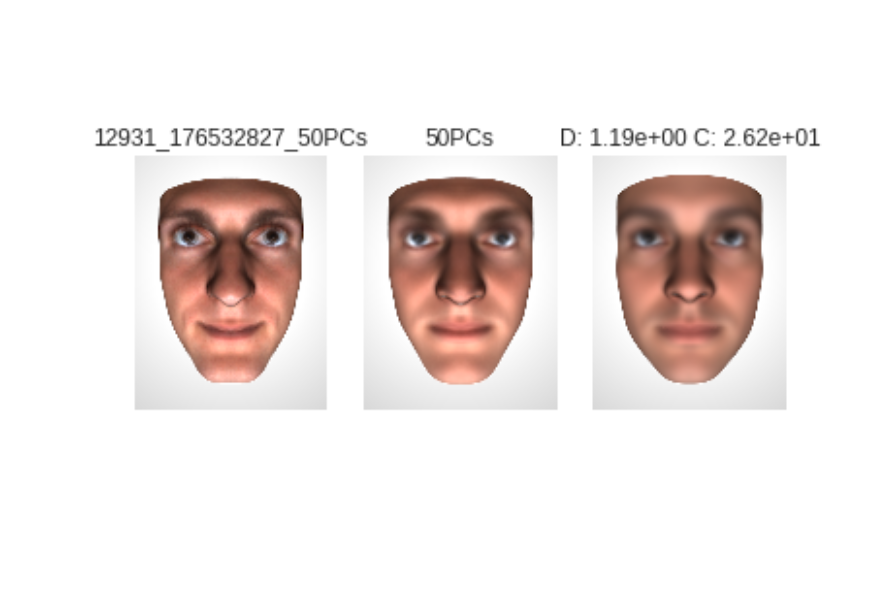

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
img_conv = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img_conv)
plt.show()